In [2]:
!pip3 install gymnasium[classic_control]

  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached numpy-1.26.4.tar.gz (15.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install backend dependencies did not run successfully.
  │ exit code: 1
  ╰─> [35 lines of output]
        Using cached ninja-1.11.1.1.tar.gz (132 kB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        error: subprocess-exited-with-error
      
        Ã— Building wheel for ninja (pyproject.toml) did not run successfully.
        â”‚ exit code: 1
        â•°â”€> [13 lines of output]
            C:\Users\Admin\AppData\Local\Temp\pip-build-env-u22estq2\overlay\lib\python3.10\site-packages\setuptools_scm\git.py:308: UserWarning: git archive did not support describe output
              warnings.warn("git archi

# Environment Setup

Goal: Use DQN model to setup optimal temperature for a room <br>

Factors affecting initial temperature: <br>
<ol>
    <li> Room booking status </li>
    <li> Outside Temp</li>
    <li> Day </li>
    <li> Time </li>
</ol>

Action taken by DQN: <br>
<ol>
    <li> Increase Temperature </li>
    <li> Decrease Temperature   </li>
    <li> Maintain Temperature </li>
</ol>

Rewards for DQN : <br>
<ol>
    <li> Energy Consumption Levels</li>
    <li> User Comfort</li>

In [3]:
import gym # OpenAI env
import math
import random
import matplotlib # Plot
import matplotlib.pyplot as plt
from collections import namedtuple, deque # Python build-in data structure
from itertools import count

In [4]:
# Neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
headers = ['day_','time_','outside_temp','inside_temp','booking_status',"energy_consumption","change_in_temp"]
total_data=1008
scale=1

#generate DAY (first column of data)
day_ = []
day_in_week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(6*scale):
    for day in day_in_week:
        for j in range(24):
            day_.append(day)

#generate TIME (second column of data)
time_ = []
for i in range(6*7*scale):
    for j in range(24):
        if j%2==1:
            time_.append(int(j/2)*100+830)
        else:
            time_.append(int(j/2)*100+800)

import numpy as np
#generate OUTSIDE_TEMP (third column of data)
outside_temp = []
mean = 30
std_dev = 1
day_temp = np.random.normal(mean, std_dev, size=42*scale)
day_temp = np.round(day_temp, decimals=1)
for day_mean in day_temp:
    for i in range(24):
        hour_temp = np.random.normal(day_mean, 0.5)
        hour_temp = np.round(hour_temp, decimals=1)
        outside_temp.append(hour_temp)
print(outside_temp)

#generate INSIDE_TEMP (fourth column of data)
inside_temp = []
mean = 22
std_dev = 2
inside_day_temp = np.random.normal(mean, std_dev, size=42*scale)
inside_day_temp = np.round(inside_day_temp, decimals=1)
for inside_day_mean in inside_day_temp:
    for i in range(24):
        inside_hour_temp = np.random.normal(inside_day_mean, 1)
        inside_hour_temp = np.round(inside_hour_temp, decimals=1)
        inside_temp.append(inside_hour_temp)
print(inside_temp)

#generate BOOKING_STATUS (fifth column of data)
booking_status = []
bernoulli_values = np.random.binomial(n=1, p=0.7, size=24*7)
for i in range(6*scale):
    for j in range(24*7):
        booking_status.append(bernoulli_values[j])
print(booking_status)

#generate ENERGY_CONSUMPTION (sixth column of data)
energy_consumption = []
optimal_consumption = 3000
for i in range(1008*scale):
    hourly_consumption = 3000 + abs(inside_temp[i]-25)*125 + np.random.normal(100, 20)
    energy_consumption.append(hourly_consumption)

#generate CHANGE_IN_TEMP (seventh column of data)
change_in_temp = []
for i in range(1008*scale):
    if booking_status[i]==0:
        change_in_temp.append(0)
    elif inside_temp[i]<20:
        change_in_temp.append(np.random.randint(0, 4))
    elif inside_temp[i]<23:
        change_in_temp.append(np.random.randint(-2, 3))
    else:
        change_in_temp.append(np.random.randint(-2, 1))


[29.4, 29.7, 30.0, 29.3, 29.5, 28.6, 29.7, 29.7, 29.6, 28.9, 29.4, 30.6, 29.9, 29.4, 29.7, 30.0, 30.4, 30.8, 29.8, 29.9, 29.9, 29.6, 30.3, 29.4, 30.9, 30.5, 30.1, 30.4, 30.1, 30.9, 30.2, 30.7, 30.6, 29.3, 29.9, 30.1, 30.0, 30.3, 30.7, 30.4, 30.2, 30.9, 30.3, 30.8, 31.5, 29.6, 30.1, 29.7, 30.2, 30.2, 29.3, 29.6, 29.9, 29.9, 30.6, 29.3, 29.7, 30.7, 29.7, 30.0, 30.9, 29.2, 30.4, 29.9, 30.0, 30.3, 30.1, 30.7, 29.4, 30.1, 30.1, 30.6, 31.1, 29.9, 30.9, 30.8, 31.6, 30.2, 31.0, 29.9, 30.5, 30.8, 31.4, 31.4, 30.0, 30.6, 30.7, 30.2, 30.6, 31.1, 29.4, 30.3, 31.0, 30.6, 31.2, 29.8, 30.0, 28.7, 28.0, 27.9, 29.3, 28.7, 29.0, 29.6, 28.8, 28.9, 29.1, 29.0, 29.9, 29.0, 28.1, 28.8, 30.1, 29.4, 29.5, 29.7, 29.3, 29.2, 28.8, 28.9, 27.8, 27.7, 28.9, 27.8, 27.9, 28.5, 28.6, 28.6, 29.0, 27.3, 27.8, 28.4, 28.0, 27.2, 28.6, 28.7, 28.0, 28.0, 28.3, 27.2, 28.7, 28.6, 28.1, 28.4, 29.4, 30.5, 30.6, 30.5, 29.3, 30.4, 30.3, 30.6, 30.7, 29.7, 29.8, 30.2, 30.2, 30.0, 30.4, 29.7, 30.1, 30.8, 30.4, 30.9, 30.0, 30.4, 30.

In [6]:
from openpyxl import Workbook

# Create a new workbook
workbook = Workbook()

# Access the active sheet
sheet = workbook.active

sheet.append(headers)

for i in range(1008*scale):
    sheet.append([day_[i], time_[i], outside_temp[i], inside_temp[i], booking_status[i], energy_consumption[i], change_in_temp[i]])

# Save the workbook
workbook.save('output.xlsx')

In [7]:
# Machine Learning to predict energy consumption

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
training_data = pd.read_excel('output.xlsx')
# for day data change mon to 1, tue to 2 etc

training_data['day_'] = training_data['day_'].replace(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],[1,2,3,4,5,6,7])
features = ['day_', 'time_', 'outside_temp', 'inside_temp', 'booking_status']
X = training_data[features]
y = training_data['energy_consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random forest model to predict energy consumption

rf_model = RandomForestRegressor(n_estimators=200, random_state= 50) # 200 trees, random_state for reproducibility
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# percentage error
percentage_error = (np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
print(f"Percentage Error: {percentage_error}")

Mean Squared Error: 547.1190668866069
Percentage Error: 0.5270235599249095


In [24]:
# Equation to calculate energy consumption
def energy_consumption(day, time, outside_temp, inside_temp, booking_status):
    day = day
    time = time
    outside_temp = outside_temp
    inside_temp = inside_temp
    booking_status = booking_status
    energy_consumption = rf_model.predict([[day, time, outside_temp, inside_temp, booking_status]])
    return energy_consumption

def user_comfort(outside_temp, inside_temp, booking_status):
    if(booking_status == 0):
        change_in_temp = 0
    elif(booking_status == 1):
        if(outside_temp < 25): #cold weather
            if (inside_temp < 20):
                change_in_temp = np.random.randint(0, 6)
            elif (inside_temp < 23):
                change_in_temp = np.random.randint(0,3)
            else:
                change_in_temp = np.random.randint(-2, 1)
        else: #hot weather
            if (inside_temp < 20):
                change_in_temp = np.random.randint(0, 2)
            elif (inside_temp < 23):
                change_in_temp = np.random.randint(-2, 3)
            else:
                change_in_temp = np.random.randint(-5, 3)
    new_temp = inside_temp + change_in_temp
    return new_temp
            


In [19]:
import gym
import numpy as np
from gym import spaces
import random

class ThermostatEnvironment(gym.Env):
    def __init__(self):
        super(ThermostatEnvironment, self).__init__()
        self.day = 1
        self.time = 1
        self.booking_status = 0
        self.temperature = 18 # temp set by machine
        self.outside_temp = random.randint(23, 40)
        self_insie_temp = user_comfort(self.outside_temp, self.temperature, self.booking_status)
        self.action_space = spaces.Discrete(3)  # Increase, Decrease, Maintain
        self.observation_space = spaces.Box(low=np.array([1, 1, 0, 23, 18]), high=np.array([5, 24, 1, 40, 25]), dtype=np.float32)
        self.max_temp = 25
        self.min_temp = 18
        self.reward = 0
        self.done = False

    def step(self, action):
        # Action logic
        if action == 0:  # Decrease temperature (too hot)
            self.temperature -= 1
        elif action == 2:  # Increase temperature (too cold)
            self.temperature += 1
        else:  # Maintain temperature
            pass

        # Ensure temperature is within bounds
        self.temperature = np.clip(self.temperature, self.min_temp, self.max_temp)

        # Calculate energy consumption
        energy = energy_consumption(self.day, self.time, self.outside_temp, self.inside_temp, self.booking_status)

        # Calculate reward
        # Adjust the energy_reward calculation
        energy_reward = -((energy - 3200) / 3200)**2  # Quadratic penalty for deviation

        # Introduce a threshold for acceptable energy consumption
        acceptable_energy_threshold = 3200
        if energy <= acceptable_energy_threshold:
            energy_reward += 0.2
        print(f"Energy Reward: {energy_reward}")

        # Modify the comfort_reward calculation
        temperature_range_penalty = 0.1  # Adjust based on your criteria
        comfort_reward = temperature_range_penalty * (self.temperature - self.inside_temp)**2

        print(f"Comfort Reward: {comfort_reward}")

        # Adjust the weights and introduce a trade-off factor
        trade_off_factor = 0.4  # Adjust based on your desired trade-off
        reward = (1 - trade_off_factor) * energy_reward + trade_off_factor * comfort_reward
        print(f"Total Reward: {reward}")

        self.reward += reward
        self.done = True

        return np.array([self.day, self.time, self.booking_status, self.outside_temp, self.inside_temp]), reward, self.done, {}

    def reset(self):
        self.day = random.randint(1, 7)
        self.time = random.randint(1, 24)
        self.booking_status = random.randint(0, 1)
        self.outside_temp = random.randint(23, 40)
        self.temperature = 18 # temp set by machine
        self.inside_temp = user_comfort(self.outside_temp, self.temperature, self.booking_status)
        self.done = False
        return np.array([self.day, self.time, self.booking_status, self.outside_temp, self.inside_temp])

    def render(self):
        pass


# Q Network

In [20]:
# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import copy

class DQN(nn.Module):
    def __init__(self, input_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 25)  # 5 input features, 1 output features
        self.fc2 = nn.Linear(25,25)
        self.fc3 = nn.Linear(25, action_size) # 10 input features, 2 output features

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [21]:
# memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            self.memory.append((state, action, next_state, reward))
        else:
            self.memory.pop(0)
            self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Training

In [22]:
# Train the model

# Hyperparameters
learning_rate = 0.0005
gamma = 0.99
buffer_limit = 100000
batch_size = 64
tau = 0.0005
input_size = 5
action_size = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the environment
env = ThermostatEnvironment()
env.reset()

# Initialize the model
model = DQN(input_size, action_size).to(device)
target_model = copy.deepcopy(model)
target_model.load_state_dict(model.state_dict())
target_model.eval()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize the replay buffer
replay_buffer = []
replay_buffer_size = 0

# Initialize the training parameters
if torch.cuda.is_available():
    print('Using GPU')
    num_episodes = 500
else:
    print('Using CPU')
    num_episodes = 100
epsilon = 0.1
epsilon_decay = 0.99
epsilon_min = 0.01
update_every = 10
update_count = 0
loss_fn = nn.MSELoss()


# Get number of actions from gym action space
n_actions = env.action_space.n

# Get number of states from gym observation space
state,info = env.reset(),{}
n_states = len(state)

policy_net = DQN(n_states, n_actions).to(device)
target_net = DQN(n_states, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=0.01)
memory = ReplayMemory(10000)

def select_action(state, epsilon):
    global steps_done
    sample = random.random()
    eps_threshold = epsilon
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episodes_duration = []

def optimize_model():
    if len(memory) < batch_size:
        return None

    # Sample a batch from the replay memory
    batch = memory.sample(batch_size)

    # Unpack the batch
    state_batch, action_batch, next_state_batch, reward_batch = map(torch.cat, zip(*batch))
    action_batch = action_batch.view(-1, 1).long()

    # Compute Q-values for the current state-action pairs
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute Q-values for the next state and find the maximum
    next_state_values = target_net(next_state_batch).max(1)[0].detach()

    # Compute the expected Q-values using the Bellman equation
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Calculate the Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


Using CPU


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid fea

Energy Reward: [-0.0599304]
Comfort Reward: -0.2
Total Reward: [-0.11595824]
Episode 0, Total Reward: -0.11595823615789413, Loss: None
Energy Reward: [-0.0599304]
Comfort Reward: -0.2
Total Reward: [-0.11595824]
Episode 1, Total Reward: -0.11595823615789413, Loss: None
Energy Reward: [-0.05998704]
Comfort Reward: -0.2
Total Reward: [-0.11599222]
Episode 2, Total Reward: -0.1159922257065773, Loss: None
Energy Reward: [-0.06003968]
Comfort Reward: -0.2
Total Reward: [-0.11602381]
Episode 3, Total Reward: -0.11602380871772766, Loss: None
Energy Reward: [-0.03968153]
Comfort Reward: -1.2
Total Reward: [-0.50380892]
Episode 4, Total Reward: -0.5038089156150818, Loss: None
Energy Reward: [-0.0599304]
Comfort Reward: -0.2
Total Reward: [-0.11595824]
Episode 5, Total Reward: -0.11595823615789413, Loss: None
Energy Reward: [-0.03968153]
Comfort Reward: -1.2
Total Reward: [-0.50380892]
Episode 6, Total Reward: -0.5038089156150818, Loss: None
Energy Reward: [-0.05991223]
Comfort Reward: -0.2
Tota

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid fea

Energy Reward: [-0.04091099]
Comfort Reward: -1.2
Total Reward: [-0.50454659]
Episode 11, Total Reward: -0.504546582698822, Loss: None
Energy Reward: [-0.05873885]
Comfort Reward: -0.2
Total Reward: [-0.11524331]
Episode 12, Total Reward: -0.11524330824613571, Loss: None
Energy Reward: [-0.0168202]
Comfort Reward: -3.2
Total Reward: [-1.29009212]
Episode 13, Total Reward: -1.29009211063385, Loss: None
Energy Reward: [-0.05444912]
Comfort Reward: -0.2
Total Reward: [-0.11266947]
Episode 14, Total Reward: -0.11266947537660599, Loss: None
Energy Reward: [-0.05926154]
Comfort Reward: -0.2
Total Reward: [-0.11555692]
Episode 15, Total Reward: -0.11555691808462143, Loss: None
Energy Reward: [-0.05444912]
Comfort Reward: -0.2
Total Reward: [-0.11266947]
Episode 16, Total Reward: -0.11266947537660599, Loss: None
Energy Reward: [-0.05387641]
Comfort Reward: -0.2
Total Reward: [-0.11232584]
Episode 17, Total Reward: -0.11232583969831467, Loss: None
Energy Reward: [-0.0604903]
Comfort Reward: -0.

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid fea

Energy Reward: [-0.05339198]
Comfort Reward: -0.2
Total Reward: [-0.11203519]
Episode 27, Total Reward: -0.11203519254922867, Loss: None
Energy Reward: [-0.05878801]
Comfort Reward: -0.2
Total Reward: [-0.11527281]
Episode 28, Total Reward: -0.11527280509471893, Loss: None
Energy Reward: [-0.0604903]
Comfort Reward: -0.2
Total Reward: [-0.11629418]
Episode 29, Total Reward: -0.11629418283700943, Loss: None
Energy Reward: [-0.0411628]
Comfort Reward: -1.2
Total Reward: [-0.50469768]
Episode 30, Total Reward: -0.5046976804733276, Loss: None
Energy Reward: [-0.0168202]
Comfort Reward: -3.2
Total Reward: [-1.29009212]
Episode 31, Total Reward: -1.29009211063385, Loss: None
Energy Reward: [-0.05926154]
Comfort Reward: -0.2
Total Reward: [-0.11555692]
Episode 32, Total Reward: -0.11555691808462143, Loss: None
Energy Reward: [-0.05926154]
Comfort Reward: -0.2
Total Reward: [-0.11555692]
Episode 33, Total Reward: -0.11555691808462143, Loss: None
Energy Reward: [-0.05878801]
Comfort Reward: -0.

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid fea

Energy Reward: [-0.03991093]
Comfort Reward: -1.2
Total Reward: [-0.50394656]
Episode 40, Total Reward: -0.5039465427398682, Loss: None
Energy Reward: [-0.06008613]
Comfort Reward: -0.2
Total Reward: [-0.11605168]
Episode 41, Total Reward: -0.11605168133974075, Loss: None
Energy Reward: [-0.05998704]
Comfort Reward: -0.2
Total Reward: [-0.11599222]
Episode 42, Total Reward: -0.1159922257065773, Loss: None
Energy Reward: [-0.05438659]
Comfort Reward: -0.2
Total Reward: [-0.11263195]
Episode 43, Total Reward: -0.11263195425271988, Loss: None
Energy Reward: [-0.0533976]
Comfort Reward: -0.2
Total Reward: [-0.11203856]
Episode 44, Total Reward: -0.11203856021165848, Loss: None
Energy Reward: [-0.04092337]
Comfort Reward: -1.2
Total Reward: [-0.50455402]
Episode 45, Total Reward: -0.504554033279419, Loss: None
Energy Reward: [-0.0604903]
Comfort Reward: -0.2
Total Reward: [-0.11629418]
Episode 46, Total Reward: -0.11629418283700943, Loss: None
Energy Reward: [-0.05824935]
Comfort Reward: -0

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid fea

Energy Reward: [-0.0604903]
Comfort Reward: -0.2
Total Reward: [-0.11629418]
Episode 56, Total Reward: -0.11629418283700943, Loss: None
Energy Reward: [-0.0395694]
Comfort Reward: -1.2
Total Reward: [-0.50374164]
Episode 57, Total Reward: -0.5037416219711304, Loss: None
Energy Reward: [-0.04085719]
Comfort Reward: -1.2
Total Reward: [-0.50451432]
Episode 58, Total Reward: -0.5045143365859985, Loss: None
Energy Reward: [-0.06003968]
Comfort Reward: -0.2
Total Reward: [-0.11602381]
Episode 59, Total Reward: -0.11602380871772766, Loss: None
Energy Reward: [-0.04110667]
Comfort Reward: -1.2
Total Reward: [-0.504664]
Episode 60, Total Reward: -0.5046640038490295, Loss: None
Energy Reward: [-0.05339198]
Comfort Reward: -0.2
Total Reward: [-0.11203519]
Episode 61, Total Reward: -0.11203519254922867, Loss: None
Energy Reward: [-0.03956975]
Comfort Reward: -1.2
Total Reward: [-0.50374185]
Episode 62, Total Reward: -0.5037418603897095, Loss: None
Energy Reward: [-0.05492997]
Comfort Reward: -0.2

C:\Users\Admin\AppData\Local\Temp\ipykernel_5772\1577032265.py:90: UserWarning: Using a target size (torch.Size([64, 1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_5772\1577032265.py:90: UserWarning: Using a target size (torch.Size([64, 1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
c:\Users\Admin\AppData\Loca

Episode 68, Total Reward: -0.5038114786148071, Loss: 0.30871471762657166
Energy Reward: [-0.05862408]
Comfort Reward: -0.2
Total Reward: [-0.11517445]
Episode 69, Total Reward: -0.11517444998025894, Loss: 0.1275295466184616
Energy Reward: [-0.05878801]
Comfort Reward: -0.2
Total Reward: [-0.11527281]
Episode 70, Total Reward: -0.11527280509471893, Loss: 0.0671902596950531
Energy Reward: [-0.05492997]
Comfort Reward: -0.2
Total Reward: [-0.11295798]
Episode 71, Total Reward: -0.11295798420906067, Loss: 0.07244813442230225
Energy Reward: [-0.0604903]
Comfort Reward: -0.2
Total Reward: [-0.11629418]
Episode 72, Total Reward: -0.11629418283700943, Loss: 0.044726550579071045
Energy Reward: [-0.04085719]
Comfort Reward: -0.1
Total Reward: [-0.06451432]
Episode 73, Total Reward: -0.06451431661844254, Loss: 0.0799875557422638
Energy Reward: [-0.0599304]
Comfort Reward: -0.2
Total Reward: [-0.11595824]
Episode 74, Total Reward: -0.11595823615789413, Loss: 0.11106987297534943
Energy Reward: [-0.

C:\Users\Admin\AppData\Local\Temp\ipykernel_5772\1577032265.py:90: UserWarning: Using a target size (torch.Size([64, 1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_5772\1577032265.py:90: UserWarning: Using a target size (torch.Size([64, 1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
c:\Users\Admin\AppData\Loca

Energy Reward: [-0.00241233]
Comfort Reward: -5.2
Total Reward: [-2.0814474]
Episode 86, Total Reward: -2.0814473628997803, Loss: 0.1055368110537529
Energy Reward: [-0.05987081]
Comfort Reward: -0.2
Total Reward: [-0.11592249]
Episode 87, Total Reward: -0.1159224882721901, Loss: 0.0809573382139206
Energy Reward: [-0.04092337]
Comfort Reward: -1.2
Total Reward: [-0.50455402]
Episode 88, Total Reward: -0.504554033279419, Loss: 0.06342743337154388
Energy Reward: [-0.05926154]
Comfort Reward: -1.1
Total Reward: [-0.47555692]
Episode 89, Total Reward: -0.4755569100379944, Loss: 0.07640998065471649
Energy Reward: [-0.0604903]
Comfort Reward: -1.1
Total Reward: [-0.47629418]
Episode 90, Total Reward: -0.4762941896915436, Loss: 0.07606787234544754
Energy Reward: [-0.06003968]
Comfort Reward: -1.1
Total Reward: [-0.47602381]
Episode 91, Total Reward: -0.47602379322052, Loss: 0.08412054926156998
Energy Reward: [-0.05899292]
Comfort Reward: -0.2
Total Reward: [-0.11539575]
Episode 92, Total Rewar

C:\Users\Admin\AppData\Local\Temp\ipykernel_5772\1577032265.py:90: UserWarning: Using a target size (torch.Size([64, 1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_5772\1577032265.py:90: UserWarning: Using a target size (torch.Size([64, 1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
c:\Users\Admin\AppData\Loca

Energy Reward: [-0.04091575]
Comfort Reward: -1.2
Total Reward: [-0.50454945]
Episode 95, Total Reward: -0.5045494437217712, Loss: 0.0731925368309021
Energy Reward: [-0.05387247]
Comfort Reward: -0.2
Total Reward: [-0.11232348]
Episode 96, Total Reward: -0.11232348531484604, Loss: 0.06426738947629929
Energy Reward: [-0.05998704]
Comfort Reward: -1.1
Total Reward: [-0.47599222]
Episode 97, Total Reward: -0.47599223256111145, Loss: 0.07709915935993195
Energy Reward: [-0.06003968]
Comfort Reward: -0.2
Total Reward: [-0.11602381]
Episode 98, Total Reward: -0.11602380871772766, Loss: 0.060011833906173706
Energy Reward: [-0.05444912]
Comfort Reward: -0.2
Total Reward: [-0.11266947]
Episode 99, Total Reward: -0.11266947537660599, Loss: 0.06790995597839355


C:\Users\Admin\AppData\Local\Temp\ipykernel_5772\1577032265.py:90: UserWarning: Using a target size (torch.Size([64, 1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_5772\1577032265.py:90: UserWarning: Using a target size (torch.Size([64, 1, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
c:\Users\Admin\AppData\Loca

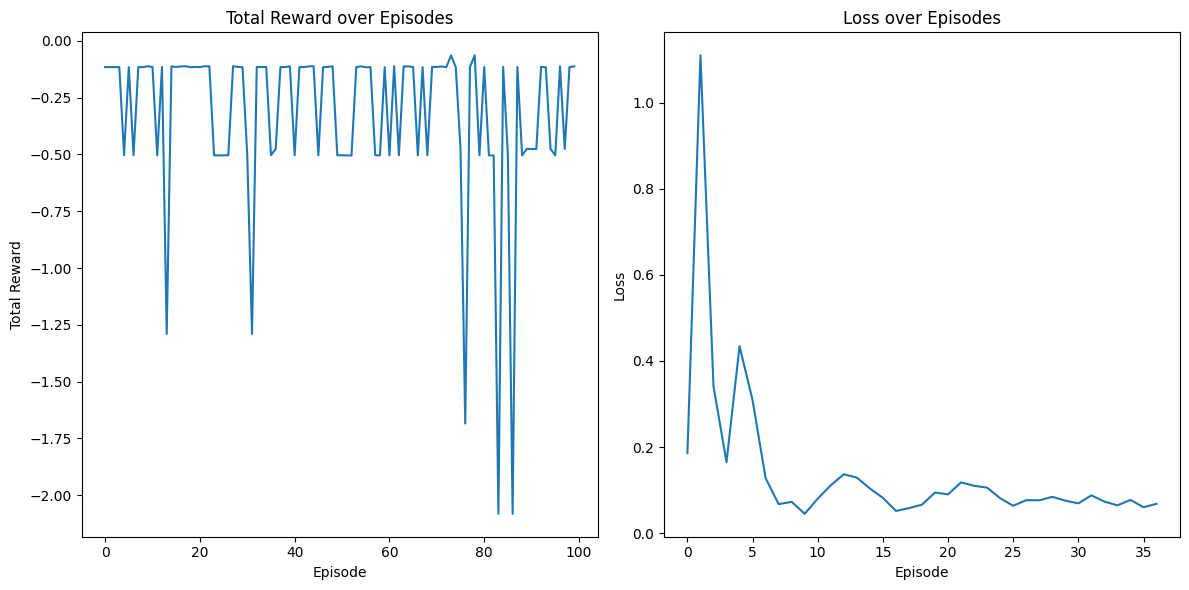

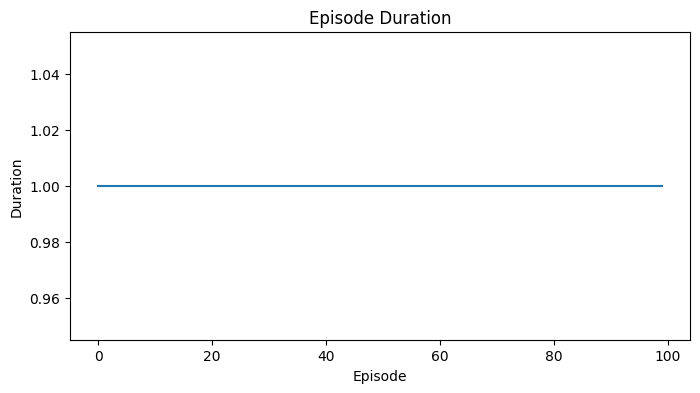

In [23]:
# Training loop

import matplotlib.pyplot as plt

episode_rewards = []
episode_losses = []
episodes_duration = []

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float32)
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.tensor([next_state], device=device, dtype=torch.float32)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        memory.push(state, action, next_state, reward)
        state = next_state
        total_reward += reward.item()
        loss = optimize_model()
        steps += 1

    # Check if loss is not None before accessing 'item'
    if loss is not None:
        episode_losses.append(loss.item())

    episode_rewards.append(total_reward)
    episodes_duration.append(steps)

    print(f"Episode {episode}, Total Reward: {total_reward}, Loss: {loss}")

    if episode % update_every == 0:
        target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Plot total rewards and losses
plt.figure(figsize=(12, 6))

# Plot the total rewards
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward over Episodes')

# Plot the losses
plt.subplot(1, 2, 2)
plt.plot(episode_losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss over Episodes')

plt.tight_layout()
plt.show()

# Plot the duration of each episode
plt.figure(figsize=(8, 4))
plt.plot(episodes_duration)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Episode Duration')
plt.show()
